# Spontaneous emission of a photon

In [1]:
import numpy as np
import scipy.sparse as sp
import dataclasses
from typing import Optional, Callable

Matrix = sp.spmatrix | np.ndarray
Vector = np.ndarray

In [2]:
import matplotlib.pyplot as plt
plt.style.use('./plots.mplstyle')

## The model

Let us consider a qubit in a chiral waveguide of length $L$, coupled according to the spin-boson model
$$
H = \Delta \sigma^+ \sigma^- + \sum_k (g_k \sigma^+ b_k + \mathrm{H.c.}) + \sum_k \hbar\omega_k b_k^\dagger b_k.
$$

We are going to solve this problem using the Wigner-Weisskopf wavefunction
$$
\ket{\psi(t)} = e^{-i\Delta t}\left[c_1(t) \sigma^+ + \sum_k w_k(t) b_k^\dagger\right] \ket{0}\otimes\ket{\text{vac}},
$$
which is exact within the single-excitation limit.

By imposing that $\ket{\psi}$ satisfies the Schrödinger equation
$$i\frac{d}{dt}\ket{\psi(t)} = H\ket{\psi(t)},$$
we find that the coefficients of the Wigner-Weisskopf ansatz must satisfy a set of coupled ordinary differential equations
\begin{align}
i\frac{d}{dt}c_1 &= \sum_k g_k w_k,\\
i\frac{d}{dt}w_k &= \delta_k c_1,\notag
\end{align}
with the detuning $\delta_k = \omega_k - \Delta.$

## Parameterization

To solve this problem, we have to put some boundary conditions. Naturally, the initial state of the wavefunction is $c_1(0)=1$ and $w_k(0)=0$. Furthermore, we will assume that the waveguide is a ring with periodic boundary conditions and only positive momenta, with photonic eigenmodes
$$u_k(x) = \frac{1}{\sqrt{L}}\exp(ikx),\;k\geq 0.$$
The periodicity $u_k(L)=u_k(0)$ imposes the valid modes
$$k = \frac{2\pi}{L}\times\{0,1,2,\ldots\}.$$
The dispersion relation will be linear
$$\omega_k = v k$$
which introduces a time scale
$$T = \frac{L}{v},$$
the time for photons to travel around the ring. This timescale defines the separation of modes in the spectrum:
$$\Delta{k}=\frac{2\pi}{L} = \frac{2\pi}{vT}\Rightarrow \Delta{\omega} = \frac{2\pi}{T}.$$

This makes it all very easy, because our problem now only has four relevant quantities:
1. The delay $T$.
2. The qubit gap $\Delta$, which we take to be our unit of time $2\pi$.
2. The distribution of couplings $g_k$
3. The number of modes that we will include in our 

We group these parameters in the following dataclass, which will use a set of couplings with a cut-off
$$
g_k = g \times \sqrt{\omega_k} e^{-\omega_k/\omega_\text{cut}}
$$
and will choose the photon frequencies as a band of $N_\text{modes}/2$ above and below $\Delta$.

In [3]:
@dataclasses.dataclass
class QubitInWaveguide:
    T: float = 100.0
    Nmodes: int = 100
    Delta: float = 2*np.pi
    g: float = 0.01
    omega_cut: float = 2*np.pi*200

    def delta_omega(self):
        """Spacing between frequency modes."""
        return 2*np.pi/self.T

    def photon_frequencies(self) -> Vector:
        """Vector of photon frequencies around `Delta`."""
        N = round(self.Delta / self.delta_omega())
        M = self.Nmodes//2
        return np.arange(max(0, N - M), N + M + 1) * self.delta_omega()

    def photon_detunings(self) -> Vector:
        """Vector of detunings around `Delta`."""
        return self.photon_frequencies() - self.Delta

    def qubit_waveguide_couplings(self) -> Vector:
        """Vector of couplings for selected modes around the qubit."""
        omega_k = self.photon_frequencies()
        return self.g * np.sqrt(omega_k) * np.exp(-omega_k / self.omega_cut)

    def Hamiltonian(self) -> Matrix:
        """Single-excitation effective Hamiltonian in sparse form."""
        # gk is a row matrix
        gk = sp.csr_matrix(self.qubit_waveguide_couplings().reshape(1,-1))
        # delta_k is diagonal matrix with the photon detunings
        delta_k = sp.diags([self.photon_detunings()], [0], format='csr')
        return sp.bmat([[0.0*sp.eye(1), gk], [gk.T, delta_k]], format='csr',)

    def excited_qubit(self) -> Vector:
        output = np.zeros(self.photon_detunings().size + 1)
        output[0] = 1.0
        return output

For instance, the following shows the effective Hamiltonian for a problem with the qubits and one mode above and below its closest resonance frequency. In this particular problem, the qubit is resonant with the 100th mode in the waveguide:

In [4]:
QubitInWaveguide(Nmodes=2).Hamiltonian().toarray()

array([[ 0.00000000e+00,  2.48174853e-02,  2.49412641e-02,
         2.50644070e-02],
       [ 2.48174853e-02, -6.28318531e-02,  0.00000000e+00,
         0.00000000e+00],
       [ 2.49412641e-02,  0.00000000e+00,  8.88178420e-16,
         0.00000000e+00],
       [ 2.50644070e-02,  0.00000000e+00,  0.00000000e+00,
         6.28318531e-02]])

## Evolution

We are now going to solve the problem of the initially excited qubit to derive the wavepacket shape both in frequency and in time. We have to solve the equation
$$
i\frac{d}{dt} \vec{v} H = \vec{v}
$$
with the vector of coefficients that includes the amplitude of the qubit and of all photons
$$
\vec{v}^T = (c_1, w_{k_{N-M}}, w_{k_{N-M+1}},\ldots, w_{k+M})
$$

In [5]:
def evolve(H: Matrix, v0: Vector, T: float, steps: int = 100, callback: Optional[Callable] = None) -> list:
    if callback is None:
        callback = lambda t, v: v[0]
    
    output = [None] * (steps+1)
    last_t = 0.0
    v = v0
    times = np.linspace(0, T, steps+1)
    for i, t in enumerate(times):
        if t != last_t:
            dt = t - last_t
            v = sp.linalg.expm_multiply((-1j * dt) * H, v)
        output[i] = callback(t, v)
        last_t = t
    return times, np.asarray(output)

Let us run a problem using this routine, ploting the qubit excited state probability.

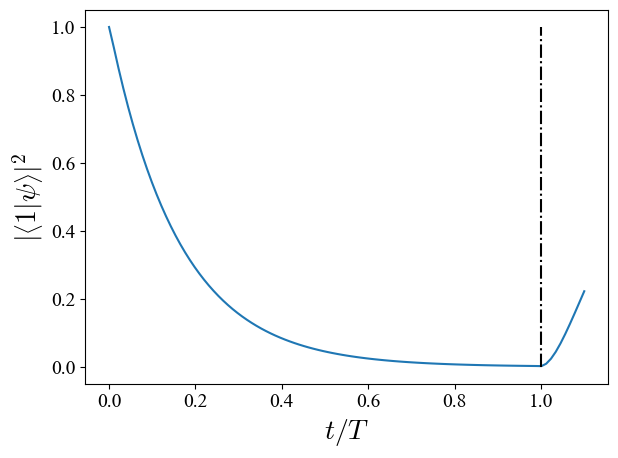

In [6]:
def expt_000():
    problem = QubitInWaveguide(Nmodes=200)
    times, c1 = evolve(problem.Hamiltonian(), problem.excited_qubit(), 110.0)

    fig, ax = plt.subplots()
    ax.plot(times / problem.T, np.abs(c1)**2)
    ax.plot([1.0, 1.0], [0, 1], 'k-.')
    ax.set_xlabel(r'$t/T$')
    ax.set_ylabel(r'$|\left\langle{1|\psi}\right\rangle|^2$')
    fig.tight_layout()

expt_000()

What we see is an almost exponential decay, which is more obvious if we use log scale (see below). Furthermore, we find that at $t=T$, the photon has returned to the qubit and begins to excited it again.

## Effective model

Before the return time $t<T$, we can effectively simulate the qubit's dynamics using the Markovian equation
$$\frac{d}{dt}c_1 = - \frac{\gamma}{2}c_1.$$
We can fit this value as a function of the coupling strength, to obtain the dependency.

Formally, the decay rate can be extracted from the kernel function
$$
K(t) = \sum_k |g_k|^2 e^{-i\delta_k t}
$$
via the integral
$$
\gamma = \int_{-T/2}^{+T/2} K(\tau)\mathrm{d}\tau.
$$
In our case, assuming that there is a momentum $\omega_{k_0}=\Delta$, we have
$$
\gamma\simeq T|g_{k_0}|^2 \simeq |g|^2 T \Delta
$$

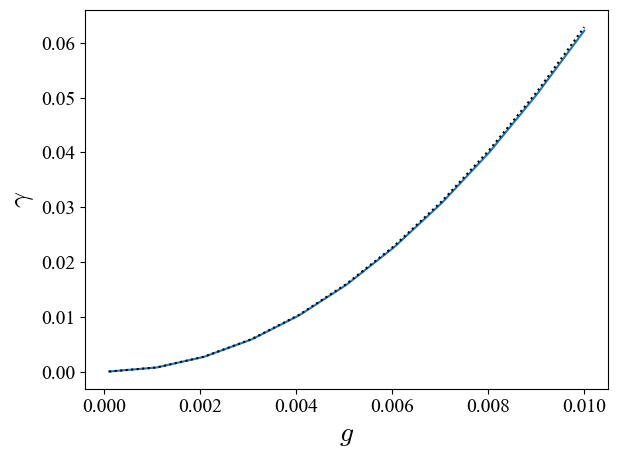

In [7]:
def expt_001():
    g = np.linspace(1e-4, 0.01, 11)
    gamma = 0.0 * g
    for i, g_i in enumerate(g):
        tmax = min(10.0 * np.sqrt(0.01 / g_i), 50)
        problem = QubitInWaveguide(Nmodes=200, g=g_i)
        times, c1 = evolve(problem.Hamiltonian(), problem.excited_qubit(), tmax)
        gamma[i] = -2 * np.log(np.abs(c1[100]/c1[50])) / (times[100] - times[50])

    fig, ax = plt.subplots()
    ax.plot(g, gamma)
    ax.plot(g, problem.Delta*problem.T*g*g, 'k:')
    ax.set_xlabel(r'$g$')
    ax.set_ylabel(r'$\gamma$')
    fig.tight_layout()

expt_001()

## Photon bandwidth

When the decay rate is sufficiently slow, only a small bandwidth of photons contributes to the dynamics. We can witness this from the simulations above, by plotting not the qubit, but the photon profiles. Note how the qubit-photon couplings don't change much across the photon's bandwidth

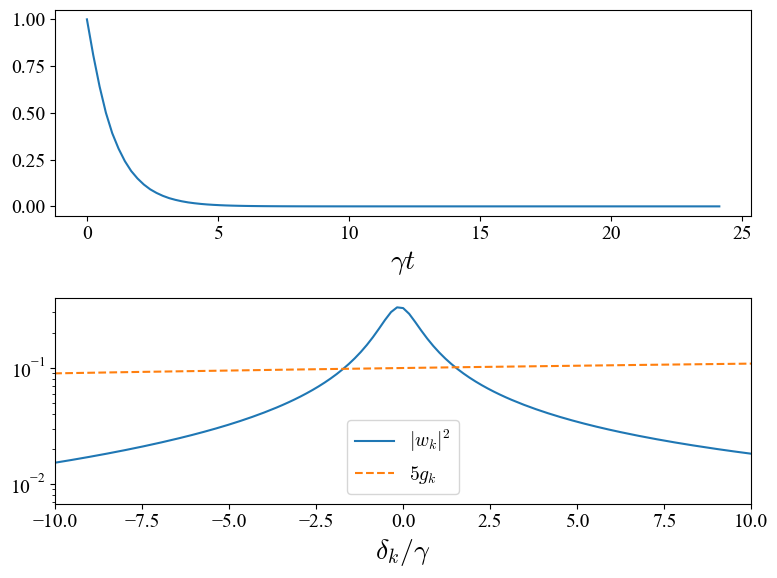

In [8]:
def expt_002():
    problem = QubitInWaveguide(Nmodes=200, g=0.008, T=300.0)
    t, c1 = evolve(problem.Hamiltonian(), problem.excited_qubit(), 200.0)
    gamma = problem.Delta*problem.T*problem.g*problem.g
    _, w = evolve(problem.Hamiltonian(), problem.excited_qubit(), 200.0,
                  callback=lambda t, v: v[1:])
    dk = problem.photon_detunings()/gamma

    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,6))
    ax1.plot(t * gamma, np.abs(c1)**2)
    ax1.set_xlabel(r'$\gamma t$')
    ax2.plot(dk, np.abs(w[-1,:]), label=r'$|w_k|^2$')
    ax2.plot(dk, 5*problem.qubit_waveguide_couplings(), '--', label=r'$5 g_k$')
    ax2.set_xlabel(r'$\delta_k/\gamma$')
    ax2.set_yscale('log')
    ax2.set_xlim([-10,10])
    ax2.legend()
    fig.tight_layout()

expt_002()